# 3-Machine Learning
Date created: 20/04/23  
Author: Jayden Dzierbicki  
Last updated: 24/04/23

The purpose of this notebook is to undertake the following 
- Import data from mySQL
- Undertake LTSM development

In [1]:
# Import necessary libraries and modules
import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import random
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


# Function to load data into mySQL
def extract_data_mySQL(database_name, table_name):
    user = 'root'

    # Prompt the user for a password
    password = getpass.getpass("Enter your MySQL password: ")
    host = 'localhost'
    port = 3306
    database = database_name
    engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

    # Write the DataFrame to a SQL table
    table_name =  table_name
    query = f"SELECT * FROM {table_name}"
    
    # Read query to dataframe
    df = pd.read_sql(query, engine)
    return(df)

    # Close the connection
    engine.dispose()


In [2]:
data = extract_data_mySQL('MA5851_A3', 'ltsm_data_frame')
data.set_index('date', inplace=True) # Index date

# Sort the data by date
data.sort_index(inplace=True)

Enter your MySQL password: ········


### Produce LTSM Model
- Extract X and Y
- Split into test and training at 20/80 respectivly, with new data being test and old being train
- Scale data to avoid data leakage after split
- Reshape data for LTSM
- Create model
- Define hyperparatmers to search
- Evulate model
- Print out model and metrics



C:\Users\jayde\AppData\Local\Temp/ipykernel_37268/1753356454.py:48: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
973/973 [==============================] - 5s 2ms/step - loss: 0.0252
Best hyperparameters: {'neurons': 25, 'learning_rate': 0.001, 'layers': 3, 'dropout_rate': 0.25, 'activation': 'tanh'}
Epoch 1/1000
973/973 [==============================] - 6s 4ms/step - loss: 0.0276 - val_loss: 0.0012
Epoch 2/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0124 - val_loss: 0.0018
Epoch 3/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0117 - val_loss: 0.0018
Epoch 4/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0114 - val_loss: 0.0016
Epoch 5/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0113 - val_loss: 0.0011
Epoch 6/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0108 - val_loss: 0.0026
Epoch 7/1000
973/973 [==============================] - 3s 3ms/step - loss: 0.0108 - val_loss: 0.0013
Epoch 8/1000
973/973 [=============

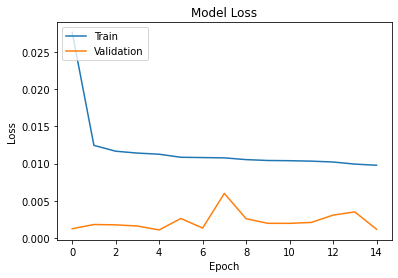

244/244 [==============================] - 1s 1ms/step
Mean Absolute Error (LSTM Model): 0.04741014845035463
Mean Absolute Error (Naive Model): 0.001629197234406353
Root Mean Squared Error (LSTM Model): 0.061197518106531124
Root Mean Squared Error (Naive Model): 0.009283449170228244


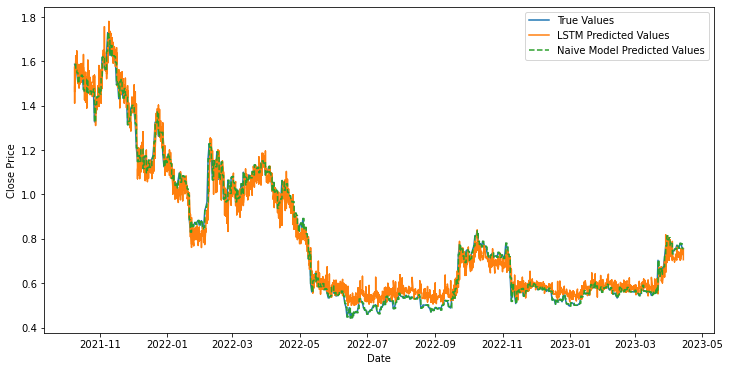

In [4]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Separate the features and target variable
X = data.drop(columns=['close'])
y = data['close']

# Split the data into training and testing sets
split_index = int(len(data) * 0.80)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Scale the features between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the target variable between 0 and 1 using MinMaxScaler
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Reshape the input data
X_train_reshaped = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

def create_model(layers=2, neurons=50, dropout_rate=0.2, learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), 
                   activation=activation,
                   return_sequences=True if layers > 1 else False))
    model.add(Dropout(dropout_rate))

    for i in range(1, layers - 1):
        model.add(LSTM(neurons, activation=activation,
                       return_sequences=True if i < layers - 2 else False))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation=activation))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


# Perform grid search to select the best hyperparameters
model = KerasRegressor(build_fn=create_model, verbose=1)

param_grid = {
    'layers': [2, 3, 4, 5],
    'neurons': [15, 25, 50, 85, 100, 150, 200, 225, 250, 270, 285, 290, 293, 294, 295, 296, 297, 300, 325, 350, 385, 400],
    'dropout_rate': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'sigmoid', 'tanh']
}

tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=48,
                                   cv=tscv, scoring='neg_mean_squared_error', verbose=1,
                                   random_state=42, n_jobs=-1)

random_search_result = random_search.fit(X_train_reshaped, y_train_scaled)

# Train and evaluate the model using the best hyperparameters with early stopping
best_model = random_search_result.best_estimator_
print("Best hyperparameters:", random_search_result.best_params_)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = best_model.fit(X_train_reshaped, y_train_scaled, validation_data=(X_test_reshaped, y_test_scaled), epochs=1000, batch_size=32, verbose=1, callbacks=[early_stopping])

# Print the training and validation losses
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

# Plot the training and validation losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make predictions on the test data
y_pred_scaled = best_model.predict(X_test_reshaped)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Compute the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (LSTM Model):', mae)

# Naive Model (Persistence Model)
y_pred_naive = y_test.shift(1).dropna()
y_test_naive = y_test[1:]
mae_naive = mean_absolute_error(y_test_naive, y_pred_naive)
print('Mean Absolute Error (Naive Model):', mae_naive)

# Compute the RMSE for the LSTM model and Naive model
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (LSTM Model):', rmse_lstm)

rmse_naive = np.sqrt(mean_squared_error(y_test_naive, y_pred_naive))
print('Root Mean Squared Error (Naive Model):', rmse_naive)

date_index = data.index[split_index:]
# Plot the true values, LSTM predictions, and naive model predictions
plt.figure(figsize=(12, 6))
plt.plot(date_index, y_test, label='True Values')
plt.plot(date_index, y_pred, label='LSTM Predicted Values')
plt.plot(date_index[1:], y_pred_naive, label='Naive Model Predicted Values', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

